**Engy-5310** Computational Continuum Transport Phenomena, UMass Lowell, Chem. Eng. Nuclear Program Spring 2021; Prof. V. F. de Almeida

# Tritium Calculation for Molten Salt Reactor
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Student(s):** Anthony Bowers  <br>
**Course:** Engy-5310 Computational Continuum Transport Phenomena  <br>
**Mentor:** Prof. Subash Sharma

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**27Mar2021**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [Approach](#app)
* [Results and Analysis](#ranalysis)
* [Conclusions](#conclusions)
* [References](#refs)
---

## [Introduction](#toc)<a id="intro"></a>

Recent technology advances are creating growing interest in nuclear reactors that require advance high temperature salt coolants like Molten Salt Reactor (MSR). In a MSR the fuel is dissolved in the coolant salt with operating temperature at a range of 700oC and 1000oC. At this temperature range the liquid salt produces tritium that can diffuse through metallic heat exchangers and escape the reactor system. To avoid exceeding allowable tritium releases to the environment, tritium removal from the salt coolant and barriers is required. 

In a lithium-containing MSR, the primary tritium-producing reactions as follow:

                                            (_3^7)LiF+n□(→) (_2^4)He+TF
                                            (_3^7)LiF+n□(→) (_2^4)He+TF+n^'
                                            (_9^19)F+n□(→) (_8^17)O+T
                                            (_4^9)〖BeF〗_2 +n□(→) (_2^4)He+(_2^4)He+2F

The production rate for the ternary fission reactions, seen above, in an FHR is given by Cisneros (2013). In addition to the production of tritium by ternary fission reactions, tritium is also produced by corrosion, where in an FHR the corrosion reaction (Oxidation of Cr) is given by. 

                                        TF+〖Cr〗_(s.s) □(→) 〖CrF〗_2+T_2(g) 

Therefore, the purpose of this project is to understand the tritium transport phenomena and select the correct model which will be tested in MOOSE. MOOSE is a partial differential solver using Finite Element Method (FEM) developed by Idaho National Laboratory. There are already existing models available in literature that have been benchmarks such as TRITium Diffusion EvolutionN and Transport (TRIDENT) developed by Stempien et al (2015,2016) at MIT. 


## [Problem Statement](#toc)<a id="problem"></a>

The project below considers tritium flow co-currently, at velocity v, with the salt coolant,FLiNak, through a heat exchangers main coolant leg.  

In [4]:

def show_domain():
    import pyvista as pv
    pv.set_plot_theme('paraview')

    length = 150
    radius = 7.5
    coolant = pv.Cylinder(center=(0,0,0), direction=(1,0,0), length=length, radius=radius_i)

    plo = pv.Plotter(notebook=True,shape=(1,2)) 

    plo.subplot(0,0)
    plo.add_mesh(coolant, color='red', opacity=1.0,)
    plo.add_axes(xlabel='R', ylabel='Theta', zlabel='Z')

    
    tmp = pv.Cylinder(center=(0,0,0), direction=(0,0,1), height=height*1.1, radius=radius_i).triangulate()
    tmp.flip_normals()

    pin = pin.boolean_cut(tmp)
    plo.subplot(0,1)

    plo.add_mesh(pv.Cylinder(center=(0,0,0), direction=(1,0,0), height=height*.98, radius=radius_i), 'red')
    cpos = plo.show(window_size=[800, 600])

## [Objectives](#toc)<a id="obj"></a>

- Text...

- Text...

## [Approach](#toc)<a id="app"></a>

- Text...

- Text...

## [Results and Analysis](#toc)<a id="ranalysis"></a>

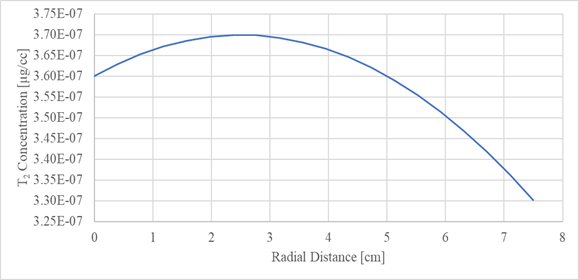

- Text...

## [Conclusions](#toc)<a id="conclusions"></a>

- Text...

- Text...

## [References](#toc)<a id="refs"></a>

- [1] V. F. de Almeida, [*Engy-5310: Computational Continuum Transport Phenomena*](https://github.com/dpploy/engy-5310), University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).
- [2] Multiphysics Object-Oriented Simulation Environment [(MOOSE)](https://mooseframework.org)
- [3] author, [reference]()
- [4] author, [reference]()